In [1]:
#Données disponibles ici: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset/data

## Projet E-commerce: Comprendre le comportement des utilisateurs du site et prédire leurs comportements futurs

## Contexte et problématique du projet:
Le site E-commerce de vente de biens de consommation est confronté à un très faible taux de consersion: malgré un nombre élevé de visiteurs, très peu de transactions sont réalisées. L'objectif principal est donc d'identifier des opportunités de croissance et ainsi d'améliorer de manière significative ce taux. 

Pour y arriver, nous ferons une exploration des données pour comprendre les préférences des consommateurs, les performances des produits et utiliserons la méthode Kmeans pour identifier les groupes d'acheteurs à potentiels et leurs caractéristiques communes.



**Comment naviguent-ils sur le site?**

**Quelle est la proportion de produits achetés/vus/ajoutés au panier**

**Observons nous des pics d'acahat sur un mois en particulier?**

**Quelles sont les catégories de produits qui ont le plus d'event (vu/ajoutés/achetés)**

**Découper les acheteurs en clusters (grâce à la méthode Kmeans)**

**Déterminer le groupe susceptible de faire des transactions**

**Identifier les catégories de produits qu'ils sont susceptible d'acheter**

## Importation des packages nécessaires

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px


## Exploration des datasets
**Fichier 1: item_properties_part1** : 10999999 lignes, 4 colonnes

In [3]:
#Import et affichage du jeu de données item_properties_part1
path="C:/Users/miche/OneDrive/Documents/Mes Projets Git hub/Bases projets"
df_it_prop1= pd.read_csv(path+"/item_properties_part1.csv")
display(df_it_prop1.head(5))
print(df_it_prop1.shape)

,timestamp,itemid,property,value
0,1431226800000,59481,790,n15360.000
1,1431831600000,156781,917,828513
2,1431831600000,264312,6,319724
3,1434250800000,98113,451,1141052 n48.000
4,1437274800000,186518,available,0


(2520260, 4)


**Fichier 2: item_properties_part2**: 9275903 lignes, 4 colonnes

In [4]:
#Import et affichage du jeu de données item_properties_part2
path="C:/Users/miche/OneDrive/Documents/Mes Projets Git hub/Bases projets"
df_it_prop2= pd.read_csv(path+"/item_properties_part2.csv")
display(df_it_prop2.head(5))
print(df_it_prop2.shape)

,timestamp,itemid,property,value
0,1438484400000,256368,888,437265 1296497 n24.000 229949 651738 285933
1,1431831600000,430773,283,257131 82777 493871 n27636.000 906078 939413
2,1435460400000,381893,790,n230280.000
3,1439694000000,112867,364,245911
4,1441508400000,281368,888,162712 866993 806659 370498 1297729 n12.000 90...


(2115992, 4)


*Description des colonnes du jeu de données item_properties_part1 et 2*
1. **Timesstamp :** variable timestamp qui renseigne sur la date et l'horaire exacte.
2. **itemidid :** l'ID de l'item.
3. **property :** la propriété concernée soit la catégorie de produit surlequel le client a cliqué, soit la disponibilité du produit ect...
4. **value :** la valeur affecté au properties (Ex: le nom de la catégorie du produit). Précisons que les données catégories ont été anonymisées. Donc nous n'avons que des chiffres comme catégorie

**Concaténation de ces 2 fichiers qui ont la même structure dans un nouveau df nommé 'item'**

In [5]:
# concaténation des 2 tables properties
item=pd.concat([df_it_prop1,df_it_prop2], axis=0)

**Nettoyage du dataframe concaténé**:

*Vérification des valeurs manquantes*

*Vérification des doublons*

In [6]:
# Nbre de lignes et vérification valeurs manquantes et doublons
print("Nombre de lignes dans item:", item.shape[0])
print("Pourcentage de valeurs manquantes dans les variables de item")
display(pd.DataFrame(index=item.columns, columns=['%_valeurs_manquantes'], data= (item.isna().sum().values / len(item)*100)))
print("Doublons")
display(item.duplicated().sum())

Nombre de lignes dans item: 4636252
Pourcentage de valeurs manquantes dans les variables de item


,%_valeurs_manquantes
timestamp,0.0
itemid,0.0
property,0.0
value,0.0


Doublons


0

**Fichier 3: events** : 275 610 lignes, 5 colonnes

In [7]:
df= pd.read_csv(path+"/events.csv")
display(df.head(5))
display(len(df))

,timestamp,visitorid,event,itemid,transactionid
0,1435378983392,389525,view,187002,NaN
1,1432580061072,1179879,view,341578,NaN
2,1431732489334,958126,view,328966,NaN
3,1441164669677,527666,view,212144,NaN
4,1440180907132,1019714,view,153033,NaN


275610

*Description des colonnes du jeu de données events*
1. **Timesstamp :** variable timestamp qui renseigne sur la date et l'horaire exacte.
2. **visitordid :** l'ID des visiteurs du site.
3. **event :** l'évenement concernéé: view/ addcart/transaction
4. **iitemdid :** l'ID de l'evenement
5. **transactionid :** décrit l'id de la transaction quand une transaction été réalisé

**A ce niveau de l'exploration des fichiers de données, le fichier events nous parait plus pertinent pour la suite de l'analyse, nous allons donc récupérer les informations essentielles du dataframe item et nous allons les mettre dans le dataframe df(event)**
**Pour celà, il nous faut d'abord parcours les 2 listes d'items unique pour récupérer les items qu'ils ont en commun**. Nous mettrons ces items dans une nouvelle liste nommée liste_itemid_commun

**Récupération des items uniques du dataframe item** dans une variable nommée "liste_itemid_item"

In [8]:
#Liste item et nbre d'itemid dans item
liste_itemid_item=item.itemid.unique()
display(liste_itemid_item)
print("Nbre itemid dans item")
display(len(liste_itemid_item))

array([ 59481, 156781, 264312, ..., 206723, 352709, 170360], dtype=int64)

Nbre itemid dans item


76470

**Récupération des items uniques du dataframe df** dans une variable nommée liste_itemid_df

In [9]:
#Liste d'item et nbre d'itemid dans df
liste_itemid_df=df['itemid'].unique()
display(liste_itemid_df)
print("Nbre itemid dans item")
display(len(liste_itemid_df))

array([187002, 341578, 328966, ..., 438862, 108149, 218856], dtype=int64)

Nbre itemid dans item


90424

**Parcours des 2 listes d'items pour récupérer la liste d'items commune**

Retirer les # si vous souhaitez faire tourner la cellule ci-dessous, elle prendra au moins 15 mn à tourner au vu de la quantité d'items

In [10]:
#rechercher les itemsid qui sont dans item mais egalement dans df
#liste_itemid_commun=[]
#for i in liste_itemid_item:
  #for j in liste_itemid_df:
    #if i == j:
      #liste_itemid_commun.append(i)

#print(liste_itemid_commun)
#len(liste_itemid_commun)

**Filtrage de df en fonction des items contenus dans la liste commune**. Tous les items présents dans le df sont également présent dans items

In [11]:
#filtrage de df avec les itemid commun à item et df
df=df.loc[df['itemid'].isin(liste_itemid_item)]
df=df.reset_index(drop=True)
display(len(df))

249726

**Seules les informations sur la disponibilité ou non du produit ainsi que sa catégorie peuvent nous être utiles dans item** 

*Nous allons donc filtré le jeu de donnée item en fonction de 'available'et de 'categoryid' de la colonne item.property*

*Ensuite fusionner toutes ces informations avec le jeu de donnée df(events)*

In [12]:
#création de 2 df item_ availability et item_categ
item_availability=item.loc[item.property=='available']
item_category=item.loc[item.property=='categoryid']

In [13]:
item_category=item_category.reset_index(drop=True)
item_availability=item_availability.reset_index(drop=True)
display(item_availability.head())
display(item_category.head())

,timestamp,itemid,property,value
0,1437274800000,186518,available,0
1,1437274800000,430459,available,0
2,1433041200000,411262,available,0
3,1441508400000,289043,available,0
4,1435460400000,365407,available,0


,timestamp,itemid,property,value
0,1435460400000,35575,categoryid,1059
1,1441508400000,76417,categoryid,1244
2,1433041200000,96660,categoryid,498
3,1441508400000,244437,categoryid,438
4,1438484400000,313481,categoryid,1613


In [14]:
display(len(item_category))
display(len(item_availability))

167443

545175

**Utilisation de merge_asof pour récuprer les informations sur l'évenement d'une part et les propriétés des produits d'autre part au moment le plus précis où l'evement s'est déroulé**

In [15]:
#fusion de df avec item_availability pour récupérer les infos sur la disponibilité de nos produits
#nous utiliserons ici merge asof qui nous permettra de récupérer la disponibilité du produit à peu près au moment où l'event a été réalisé
#création merged_1

item_availability.itemid = item_availability.itemid.astype('int64')

merged_1=pd.merge_asof(df.sort_values('timestamp'),item_availability.sort_values('timestamp'),by='itemid', on='timestamp',direction='nearest')
merged_1.head()


,timestamp,visitorid,event,itemid,transactionid,property,value
0,1430622027031,1149227,view,29757,NaN,available,1
1,1430622028399,477106,view,297347,NaN,available,0
2,1430622036210,654913,view,149767,NaN,available,1
3,1430622115328,375734,view,282298,NaN,available,1
4,1430622118534,584571,view,436195,NaN,available,1


In [16]:
#création merged_2 pour récupérer à présent les categories de certains produits

item_category.itemid = item_category.itemid.astype('int64')

merged_2=pd.merge_asof(merged_1.sort_values('timestamp'),item_category.sort_values('timestamp'),by='itemid', on='timestamp',direction='nearest')
merged_2.head()

,timestamp,visitorid,event,itemid,transactionid,property_x,value_x,property_y,value_y
0,1430622027031,1149227,view,29757,NaN,available,1,categoryid,858
1,1430622028399,477106,view,297347,NaN,available,0,categoryid,1674
2,1430622036210,654913,view,149767,NaN,available,1,categoryid,368
3,1430622115328,375734,view,282298,NaN,available,1,categoryid,1613
4,1430622118534,584571,view,436195,NaN,available,1,categoryid,1090


**Le df nommé merged_2 comporte ainsi toutes les informations récupérées du df item et du df(event)**

**Nous pouvons donc procéder à son nettoyage également**

In [17]:
#suppression des colonnes property et transactionid
merged_2=merged_2.drop(['property_x','property_y','transactionid'], axis=1)

In [18]:
#renommer les colonnes pour plus de clarté
merged_2=merged_2.rename(columns={'value_x': "available", "value_y": "categoryid"})
merged_2.head()

,timestamp,visitorid,event,itemid,available,categoryid
0,1430622027031,1149227,view,29757,1,858
1,1430622028399,477106,view,297347,0,1674
2,1430622036210,654913,view,149767,1,368
3,1430622115328,375734,view,282298,1,1613
4,1430622118534,584571,view,436195,1,1090


In [19]:
merged_2.isna().sum()

timestamp     0
visitorid     0
event         0
itemid        0
available     0
categoryid    0
dtype: int64

In [20]:
merged_2.categoryid=merged_2.categoryid.astype(int)
merged_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249726 entries, 0 to 249725
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   249726 non-null  int64 
 1   visitorid   249726 non-null  int64 
 2   event       249726 non-null  object
 3   itemid      249726 non-null  int64 
 4   available   249726 non-null  object
 5   categoryid  249726 non-null  int32 
dtypes: int32(1), int64(3), object(2)
memory usage: 10.5+ MB


**Fichier 4: category** : 1669 lignes, 2 colonnes

In [21]:
tree= pd.read_csv(path+"/category_tree.csv")
display(tree.head(5))
display(len(tree))

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


1669

*Description des colonnes du jeu de données category*
1. **categoryid :** la catégorie du produit
2. **parentid:** la catégorie supérieure (parent) auxquelle est rattaché la catégorie .

*Nettoyage du jeu de données*

In [22]:
#Nbre de lignes et valeurs manquantes category
print("Nombre de lignes dans category_tree:", tree.shape[0])
print("Pourcentage de valeurs manquantes dans les variables de category_tree")
pd.DataFrame(index=tree.columns, columns=['%_valeurs_manquantes'], data= (tree.isna().sum().values / len(tree)*100))

Nombre de lignes dans category_tree: 1669
Pourcentage de valeurs manquantes dans les variables de category_tree


,%_valeurs_manquantes
categoryid,0.000000
parentid,1.497903


In [23]:
# Vérification de doublons
tree.duplicated().sum()

0

**- Dernière fusion du df merged_2 avec ce 4ième fichier pour récupérer les parentid**

In [24]:
#Nous allons à présent récuperer les informations sur les parentid correspondant à nos catégories dans tree
df_final=merged_2.merge(tree, how='left', on= 'categoryid')

**- Suite du pré processing:**

1- Création de 3 nouvelles colonnes issues de la colonne *event* pour avoir une colonne par vus/Ajout au panier/transaction

2- Conversion de timestamp en datetime

3- Création d'une colonne month

4- Vérification et derniers nettoyages

In [25]:
#création de 3 nouvelles variables à partir de la colonne event
df_final=df_final.join(pd.get_dummies(data=df_final['event']))

In [26]:
# conversion en datetime de timestamp
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'], unit='ms')
# Créer la Colonne Mois
df_final['month'] = df_final['timestamp'].dt.month

In [27]:
display(df_final.head())
display(df_final.shape)

,timestamp,visitorid,event,itemid,available,categoryid,parentid,addtocart,transaction,view,month
0,2015-05-03 03:00:27.031,1149227,view,29757,1,858,1426.0,False,False,True,5
1,2015-05-03 03:00:28.399,477106,view,297347,0,1674,1420.0,False,False,True,5
2,2015-05-03 03:00:36.210,654913,view,149767,1,368,901.0,False,False,True,5
3,2015-05-03 03:01:55.328,375734,view,282298,1,1613,250.0,False,False,True,5
4,2015-05-03 03:01:58.534,584571,view,436195,1,1090,648.0,False,False,True,5


(249726, 11)

In [28]:
#Vérification NaN, duplicated, types col
display(pd.DataFrame(index=df_final.columns, columns=['%_valeurs_manquantes'], data= (df_final.isna().sum().values / len(item)*100)))
print("Doublons")
display(df_final.duplicated().sum())
print("Types des variables")
display(df_final.dtypes)

,%_valeurs_manquantes
timestamp,0.000000
visitorid,0.000000
event,0.000000
itemid,0.000000
available,0.000000
categoryid,0.000000
parentid,0.000022
addtocart,0.000000
transaction,0.000000
view,0.000000


Doublons


5

Types des variables


timestamp      datetime64[ns]
visitorid               int64
event                  object
itemid                  int64
available              object
categoryid              int32
parentid              float64
addtocart                bool
transaction              bool
view                     bool
month                   int32
dtype: object

In [29]:
#Remplacement des fillna de parentid par 9999 qui correspond à Other
df_final['parentid'].fillna(9999, inplace=True)

In [30]:
# Conversion des variables
df_final[['available','parentid','addtocart','transaction','view']]=df_final[['available','parentid','addtocart','transaction','view']].astype(int)


In [31]:
#aperçu des doublons
duplicates_df_final = df_final[df_final.duplicated(keep=False)]
display(duplicates_df_final)
#suppression doublons car ils sont identiques
df_final=df_final.drop_duplicates()

,timestamp,visitorid,event,itemid,available,categoryid,parentid,addtocart,transaction,view,month
122572,2015-07-08 05:33:01.491,1068724,view,139207,1,161,351,0,0,1,7
122573,2015-07-08 05:33:01.491,1068724,view,139207,1,161,351,0,0,1,7
164659,2015-07-27 22:15:19.816,760596,addtocart,266900,1,1650,1426,1,0,0,7
164660,2015-07-27 22:15:19.816,760596,addtocart,266900,1,1650,1426,1,0,0,7
185446,2015-08-08 21:26:22.938,1365939,addtocart,17419,1,499,986,1,0,0,8
185447,2015-08-08 21:26:22.938,1365939,addtocart,17419,1,499,986,1,0,0,8
200400,2015-08-18 13:37:52.199,1321861,view,273872,1,535,426,0,0,1,8
200401,2015-08-18 13:37:52.199,1321861,view,273872,1,535,426,0,0,1,8
226002,2015-09-03 05:54:31.712,1241373,addtocart,191763,1,1222,105,1,0,0,9
226003,2015-09-03 05:54:31.712,1241373,addtocart,191763,1,1222,105,1,0,0,9


In [32]:
#Suppresiion des colonnes event et timestamp
df_final=df_final.drop(['event','timestamp'], axis=1)

In [33]:
display(df_final.head())
display(df_final.shape)

,visitorid,itemid,available,categoryid,parentid,addtocart,transaction,view,month
0,1149227,29757,1,858,1426,0,0,1,5
1,477106,297347,0,1674,1420,0,0,1,5
2,654913,149767,1,368,901,0,0,1,5
3,375734,282298,1,1613,250,0,0,1,5
4,584571,436195,1,1090,648,0,0,1,5


(249721, 9)

**Agrégation des données grâce au groupby sur les variables, application des fonctions d'agrégation différentes en fonction de chaque variable**

*   addtocart : somme
*   transaction : somme
*   view: somme
*   available :garder que la dernière valeur
*   categoryid":garder la première valeur
*   parentid": garder la première valeur
*   month: garder le nombre de mois unique
*   visitorid : garder le nombre de visiteurs uniques qui ont consulté le produit

In [34]:
#agreger les données
dictag={'addtocart':'sum','transaction':'sum','view':'sum','available':'last','categoryid':'first','parentid':'first','month':'nunique','visitorid':'nunique' }
df_final_ag=df_final.groupby('itemid').agg(dictag)

**Aperçu du df_final qui nous servira pour les parties Visualisation et Modèles de Machine Learning**

In [35]:
display(df_final_ag.head())
display(df_final_ag.shape)
#variable cible: Transaction

,addtocart,transaction,view,available,categoryid,parentid,month,visitorid
itemid,,,,,,,,
6,0,0,3,0,1091,573,2,3
16,0,0,4,1,333,1497,4,4
19,0,0,1,1,1171,938,1,1
25,0,0,3,1,1509,620,2,3
32,0,0,6,0,1173,805,5,6


(76470, 8)

## Après la phase pré-processing,quels sont les principaux enseignements que l'on peut tirer de ce jeu de données?

# Data Visualisation
**Comprendre les habitudes de navigation sur le site**
**Axe 1- une visualisation descriptive des données**
- Distribution du nbre de vu/ajout panier/transaction des produits
- Distribution du nbre de visiteurs pour un produit
- Quelle est la proportion de produits disponible/non disponible?
- le nbre de mois unique où les visiteurs consulte un produit?
- Quelles sont les 10 categ qui réalisent des events de vu/d'ajout panier/ de transaction des produits?

**Axe 2- Impacte des différents facteurs sur les events**
- Est-ce qu'il y a un lien entre la disponibilité ou non du produits et les vus?
- Relation entre le nbre de visiteur du produit et la transaction

**Axe 3- correlations entre les variables**
Correlation variables numériques

In [36]:
#Rappel du type des variables
#variables numériques: addcart,transaction,view,visitorid, month
#variables catégorielles:available,category,parentid

In [37]:
df_final_ag.describe()

,addtocart,transaction,view,available,categoryid,parentid,month,visitorid
count,76470.000000,76470.000000,76470.000000,76470.000000,76470.000000,76470.000000,76470.000000,76470.000000
mean,0.088139,0.028822,3.148647,0.428312,885.904695,859.310566,1.753812,3.107245
std,0.429800,0.227693,5.846591,0.494837,482.777599,503.102014,1.092687,5.723524
min,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,0.000000,461.000000,441.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,959.000000,871.000000,1.000000,1.000000
75%,0.000000,0.000000,3.000000,1.000000,1279.000000,1329.000000,2.000000,3.000000
max,39.000000,26.000000,348.000000,1.000000,1697.000000,9999.000000,5.000000,343.000000


**Descritpion univariée**

In [38]:
#Distribution du nbre de vu/add/transaction des produits
#sur la période considérée, la plupart des produits ont été vu une fois, certains entre 2 et 5 fois
#Très peu ont été ajoutés et parmis ceux-ci, le nbre d'ajout de produits est de 1 voir 2
#Il en est de même pour les transactions, une seule transaction
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=3,
                   subplot_titles = ['Distribution des views','Distribution des ajouts paniers','Distribution des transactions'])

fig.add_trace(go.Histogram(x=df_final_ag['view'],
                           marker_color = 'blue',
                           name='View',
                           marker_line = dict(width = 1, color = 'white'),
                           xbins=dict( # bins used for histogram
                            start=0,
                             end=30,
                             size=1)),
                           1,1)

fig.add_trace(go.Histogram(x=df_final_ag['addtocart'],
                           marker_color = 'orange',
                           name='Ajout panier',
                           marker_line = dict(width = 1, color = 'white'),
                           xbins=dict(
                            start=0,
                             end=10,
                             size=1)),
                           1,2)

fig.add_trace(go.Histogram(x=df_final_ag['transaction'],
                           marker_color = 'green',
                           name='Transaction',
                           marker_line = dict(width = 1, color = 'white'),
                           xbins=dict(
                            start=0,
                             end=10,
                             size=0.5)),
                           1,3)


**Au regards de ces distributions, la plupart des produits ont été vu une fois, certains entre 2 et 5 fois.**

**Le nombre d'ajout au panier est d'un produit voir 2 est assez faible par rapport au non ajout.**

**Il en est de même pour les transactions, 74k de 0 transaction vs 1.6k de transacttion**

In [39]:
#Distribution du nbre de visiteurs pour un produit
fig=go.Figure()
fig.add_trace(go.Histogram(x=df_final_ag['visitorid'],
                           marker_color = 'blue',
                           name='Nbre de visiteurs',
                           marker_line = dict(width = 1, color = 'white'),
                           xbins=dict( # bins used for histogram
                            start=0,
                             end=20,
                             size=1)))

fig.update_layout(
                    xaxis_title="Nombre de visites",
                    yaxis_title="Nombre d'observations",
                    title="Distribution du nombre de visiteurs")

**Il y a 39 217 visiteurs uniques qui se sont rendus une seule fois sur le site**

**Mais également un nombre non négligeable de visiteurs uniques qui se sont rendu deux fois ou plus sur le site**

In [40]:
values=df_final.month.value_counts()
values2=df_final_ag.month.value_counts()
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type':'domain'}, {'type':'domain'}]],
                   subplot_titles = ['Répartition des mois','Nbre de mois unique'])

fig.add_trace(go.Pie(values=values.values,
                     labels=values.index,
                     pull = [0.1,0,0,0,0],
                     legendgroup="group1",
                     legendgrouptitle_text = " Mois"),
                     1,1)
fig.add_trace(go.Pie(values=values2.values,
                     labels=values2.index,
                     pull = [0.1,0,0,0,0],
                     legendgroup="group2",
                     legendgrouptitle_text = "Mois unique"),
                     1,2)
fig.show()
#la période de juin à juillet semble être la période qui a le plus d'evènement, contrairement au mois de septembre
#le nbre de mois unique où un produit est consulté ou acheté est de généralement de 1 voir 2 (donc un cycle d'achat relativement court)

**Sur la période considérée, les mois de juin et juillet semble être la période qui a le plus d'evènement, contrairement au mois de septembre**

**Le nbre de mois unique où un produit est consulté ou acheté est de généralement de 1 voir 2 (donc un cycle d'achat relativement court?/ou un produit qui n'est pas de 1ière nécessité?)**

**Difficile d'apporter un avis métier au regard de l'anonymisation des données**

In [41]:
#La disponibilité des produits
values=df_final_ag.available.astype(str).value_counts()
fig=go.Figure([go.Bar(x=values.index,
                      y = values)])

fig.update_layout(title = 'La disponibilité des produits',
                 xaxis_title = 'Available',
                 yaxis_title = 'Count')

**Sur la période considérée, nous avons un peu plus de produits indisponibles en comparaison aux produits disponibles, ce qui a dû influencer la non réalisation des transactions sur le site**

In [42]:
topview=df_final_ag.sort_values(by='view', ascending=False).head(10)
topadd=df_final_ag.sort_values(by='addtocart', ascending=False).head(10)
toptrans=df_final_ag.sort_values(by='transaction', ascending=False).head(10)
topview.categoryid=topview.categoryid.astype(str)
topadd.categoryid=topadd.categoryid.astype(str)
toptrans.categoryid=toptrans.categoryid.astype(str)

fig2 = make_subplots(rows=1, cols=3,
                   subplot_titles = ['Top catégorie view','Top catégorie ajouts paniers','Top catégorie transactions'])

fig2.add_trace(go.Bar(x=topview.categoryid,
                      y = topview['view'],
                      name='View'),
                      1,1)
fig2.add_trace(go.Bar(x=topadd.categoryid,
                      y = topadd['addtocart'],
                      name='Addtocart'),
                      1,2)
fig2.add_trace(go.Bar(x=toptrans.categoryid,
                      y = toptrans['transaction'],
                      name='Transaction'),
                      1,3)



**Le produit phare est le produit 1037 avec 26 transactions au total pour ce produit qui a été acheté**

**Description bivariée et multivariée**

In [43]:
#relation entre le nbre de vus et les ajouts au panier
#relation entre les ajouts et les transactions
fig3 = make_subplots(rows=1, cols=3,
                   subplot_titles = ['Relation vus vs ajout panier','Relation ajout panier et transaction','Relation visiteurs et les vus'])

fig3.add_trace(go.Scatter(x=df_final_ag.view,
                          y = df_final_ag.addtocart,
                          mode = "markers"),
                          1,1)

fig3.add_trace(go.Scatter(x=df_final_ag.addtocart,
                          y = df_final_ag.transaction,
                          mode = "markers"),
                          1,2)
fig3.add_trace(go.Scatter(x=df_final_ag.visitorid,
                          y = df_final_ag.view,
                          mode = "markers"),
                          1,3)

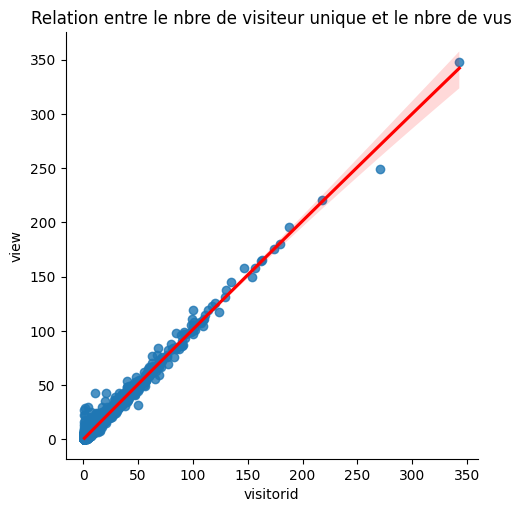

In [44]:
#relation linéaire entre le nbre de visiteur du produit et les vus
sns.lmplot(x='visitorid', y="view", data=df_final_ag, order = 2, line_kws = {'color': 'red'})
plt.title("Relation entre le nbre de visiteur unique et le nbre de vus")
plt.show()

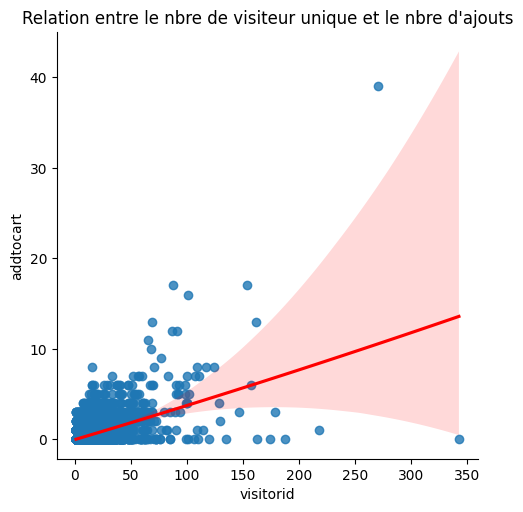

In [45]:
#relation linéaire entre le nbre de visiteur du produit et les ajouts
sns.lmplot(x='visitorid', y="addtocart", data=df_final_ag, order = 2, line_kws = {'color': 'red'})
plt.title("Relation entre le nbre de visiteur unique et le nbre d'ajouts")
plt.show()

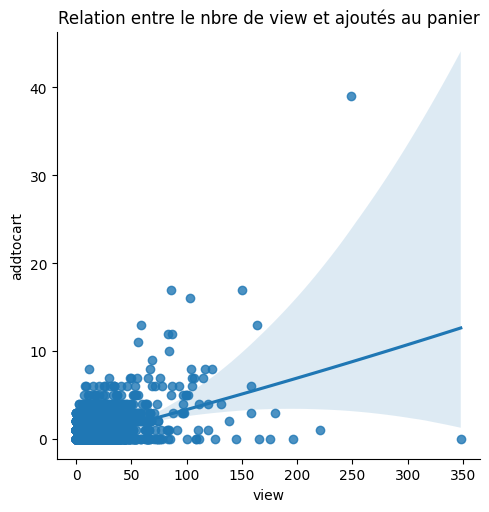

In [46]:
#relation linéaire entre le nbre de vu et le nbre d'ajout au panier=> sns.lmplot
sns.lmplot(x='view', y="addtocart", data=df_final_ag, order = 2, )
plt.title("Relation entre le nbre de view et ajoutés au panier")
plt.show()

In [47]:
var_num=df_final_ag[['addtocart','transaction','view','visitorid', 'month']]

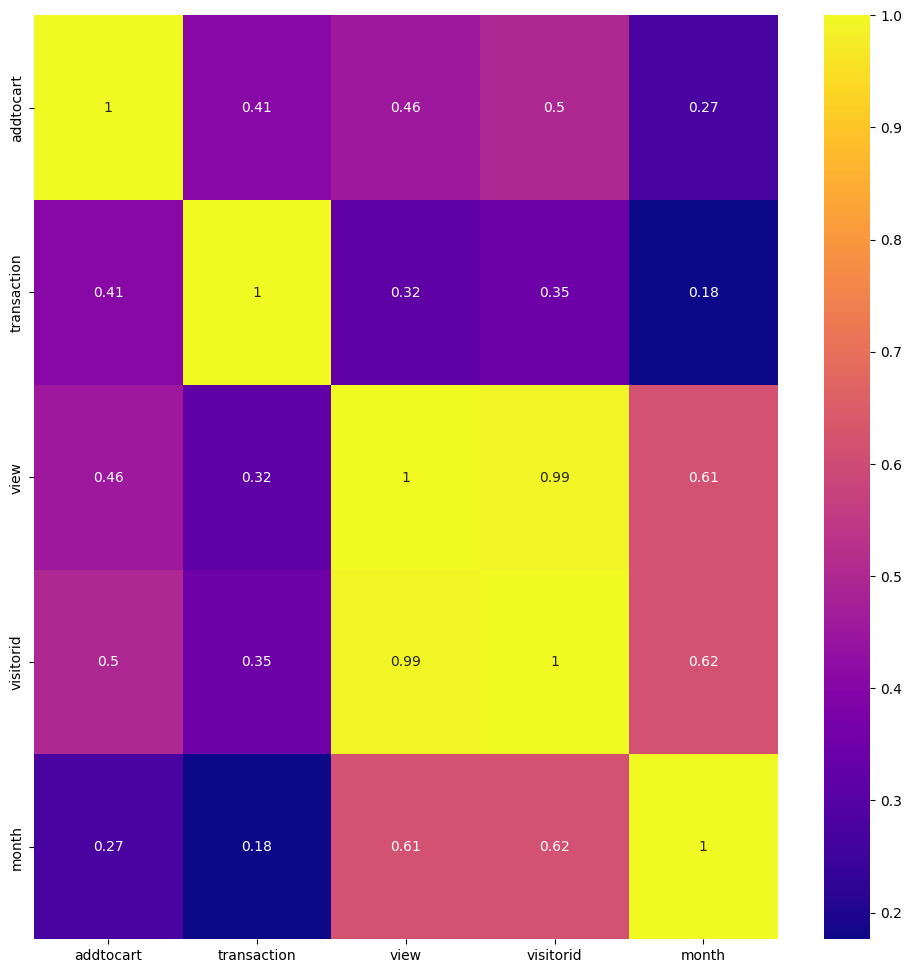

In [48]:
#De façon logique, il y a une correlation entre le nbre de Il semble avoir une plus grande correlation entre
#correlation variables numerique()
var_num=df_final_ag[['addtocart','transaction','view','visitorid', 'month']]
x=var_num.corr()
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(x, annot=True, ax=ax, cmap='plasma');

**De façon logique, il y a une correlation entre le nombre de visiteurs et le nombre de vus.**

**Celle entre le nombre de visiteurs et la transaction semble assez faible**

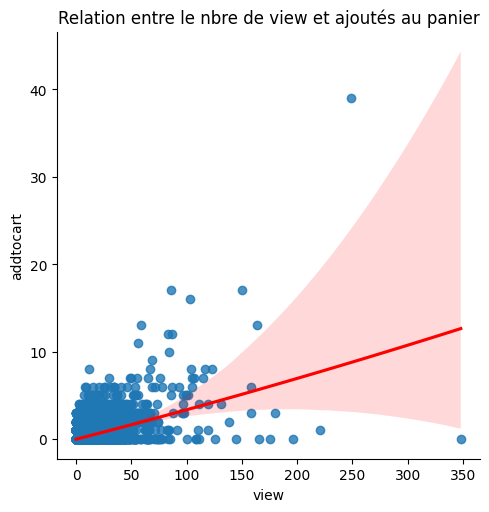

In [49]:
sns.lmplot(x='view', y="addtocart", data=df_final_ag, order = 2, line_kws = {'color': 'red'})
plt.title("Relation entre le nbre de view et ajoutés au panier")
plt.show()

## Nous allons prodécer à présent à la méthode de clustering Kmeans pour obtenir des groupes homogènes qui ont des comportements similaires

In [62]:
#clustering pour déterminer des groupes de personnes qui ont des comportements similaires.
#KMEANS
from sklearn.preprocessing import StandardScaler
 # Sélectionner uniquement les colonnes numériques
df_numeric = df_final_ag.drop(['available', 'categoryid','parentid'], axis=1)
df_normalized= df_numeric.copy()

# Normaliser les données
scaler = StandardScaler()
col=['addtocart', 'transaction' ,'view','month','visitorid' ]
df_normalized.loc[:,col]=scaler.fit_transform(df_normalized[col])

In [63]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

distorsion=[]
silhouettes = []

K = range(2, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(df_normalized)
    distorsion.append(sum(np.min(cdist(df_normalized, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / np.size(df, axis = 0))
    silhouettes.append(silhouette_score(df_normalized, kmeanModel.labels_))

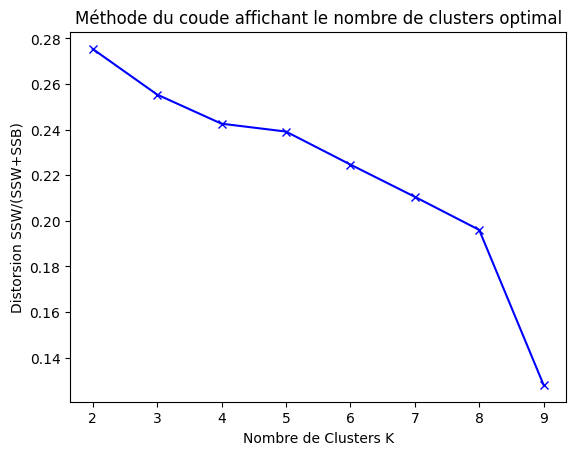

In [64]:
# Tracer la courbe de la distorsion en fonction du nombre de clusters entre 2 et 10
plt.plot(range(2, 10), distorsion, 'bx-')
plt.xlabel('Nombre de Clusters K')
plt.ylabel('Distorsion SSW/(SSW+SSB)')
plt.title('Méthode du coude affichant le nombre de clusters optimal')
plt.show()

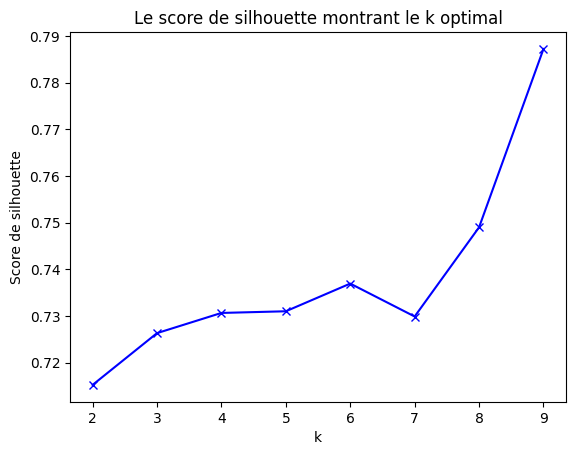

In [65]:
# Graphique du score de silhouette
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Le score de silhouette montrant le k optimal')
plt.show()

**Selon les courbes obtenues, le nombre de clusters idéale est de clusters.**

La méthode de silhouette est utile car elle fournit une mesure concise de la qualité des clusters qui prend en compte à la fois la cohésion et la séparation des clusters.

In [66]:
#selon les courbes obtenues, le nombre de cluster idéale est de 3
#Entrainement de l'algorithme sur le df, et calcul des positions des K centroïdes et les labels
clf_kmean = KMeans(n_clusters = 4, random_state=42)
clf_kmean=clf_kmean.fit(df_normalized)
centroids = clf_kmean.cluster_centers_
label = clf_kmean.labels_

print(silhouette_score(df_normalized,  clf_kmean.labels_))


0.7306705354823821


# Interprétation des groupes et conclusion

In [67]:
# Afficher les statistiques des clusters
df_final_ag['cluster_label'] = clf_kmean.labels_
cluster_stats = df_final_ag.groupby('cluster_label')[df_numeric.columns].mean()
cluster_stats

,addtocart,transaction,view,month,visitorid,cluster_label
cluster_label,,,,,,
0,0.029932,0.008345,1.542116,1.258141,1.527358,0.0
1,0.168606,0.050315,6.692429,3.453998,6.555449,1.0
2,1.203063,0.469654,24.657969,4.435621,24.552467,2.0
3,5.790323,2.258065,112.225806,4.887097,110.725806,3.0


**Nous avons le groupe 2 "Les prospects": ce groupe a une moyenne de transaction proche de 0.5 donc susceptible de faire des transactions avec un nombre elévé de visiteurs&vues**; un groupe à potentiel

**Nous avons le groupe 3 "Les Fidèles": ce groupe a une moyenne de transaction de plus de 2 avec très peu de vues et d'ajouts au panier. On peut émettre l'hypothèse qu'il s'agit des produits usuels achetés par les clients fidèles au site**

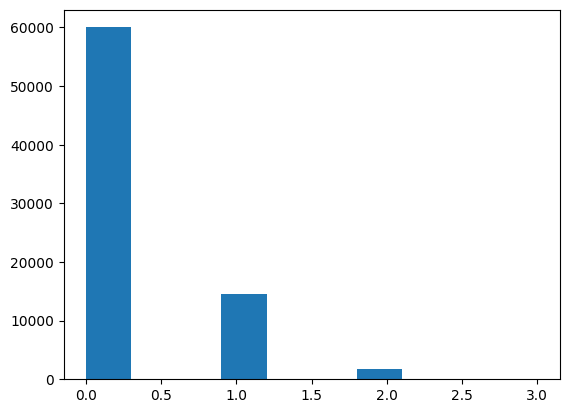

In [68]:
#Répartition de nos clusters avec la méthode des Kmeans
#Nous avons près de 60.000 observations dans le clusters n°0, nous avons peu d'observations dans le cluster n°2 et 3
plt.hist(df_final_ag['cluster_label']);

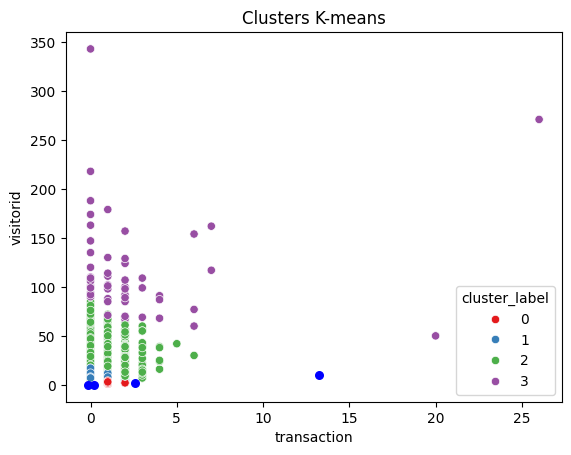

In [69]:
# Visualisation des groupes
sns.scatterplot(data=df_final_ag, x='transaction', y='visitorid', hue='cluster_label', palette='Set1')
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "o", color = "blue",s=30, linewidths = 1, zorder = 10)
plt.title("Clusters K-means")
plt.show()

## Vérifions la disponibilité des produits auprès de chaque cluster

In [70]:
#Affichage du df_final avec cluster
display(df_final_ag.head())

#Vérification de la disponibilité des produits auprès de ces clusters
# Créer une table de contingence entre cluster_label et disponibilité du produit
contingency_table = pd.crosstab(df_final_ag['cluster_label'], df_final_ag['available'], normalize=0)*100
display(contingency_table)

,addtocart,transaction,view,available,categoryid,parentid,month,visitorid,cluster_label
itemid,,,,,,,,,
6,0,0,3,0,1091,573,2,3,0
16,0,0,4,1,333,1497,4,4,1
19,0,0,1,1,1171,938,1,1,0
25,0,0,3,1,1509,620,2,3,0
32,0,0,6,0,1173,805,5,6,1


available,0,1
cluster_label,,
0,61.060679,38.939321
1,44.105969,55.894031
2,33.352240,66.647760
3,43.548387,56.451613


**Remarque: 33% des produits n'étaient pas disponibles pour le cluster 2**

## Nous allons à présent récupérer les catégories qu'ils sont susceptibles d'acheter

In [72]:
#Récuprer les categories de produits qui sont dans le clustern°1
dictag={'categoryid':'unique'}
categ_group=df_final_ag.groupby('cluster_label').agg(dictag)

print('Catégories par cluster')
display (categ_group)

print('Catégories cluster 1')
#Nous avons dans le cluster n°1 204 categories de produits à potentiel
display (categ_group.iloc[1,0])
print("Nous avons :", len(categ_group.iloc[1,0]), "catégories")

print('Catégories cluster 3')
#Nous avons dans le cluster n°1 204 categories de produits à potentiel
display (categ_group.iloc[3,0])
print("Nous avons :", len(categ_group.iloc[3,0]), "catégories")

Catégories par cluster


,categoryid
cluster_label,
0,"[1091, 1171, 1509, 1526, 1007, 586, 237, 1186,..."
1,"[333, 1173, 84, 1080, 1006, 816, 959, 586, 123..."
2,"[646, 707, 1650, 1051, 209, 847, 606, 972, 683..."
3,"[1349, 959, 789, 398, 858, 1375, 1373, 1265, 1..."


Catégories cluster 1


array([ 333, 1173,   84, 1080, 1006,  816,  959,  586, 1231,  411,  707,
       1500, 1135,  224, 1114, 1088,  799,   29, 1018, 1082, 1402, 1404,
        558, 1393,  969,  390,  771,  437,  987,    5,  523,  494, 1491,
        633, 1589,  242, 1279,  769,  282,  342, 1221,  927,  484, 1375,
       1388, 1248,  124, 1468, 1051, 1605,   47,  801, 1228, 1325,  292,
       1529, 1120, 1188, 1477, 1663,  589, 1186,  782, 1650, 1343, 1626,
       1680, 1344, 1483,  844,  575,  646, 1087,  967, 1047, 1509,  996,
        497, 1549, 1192,  806, 1578,  120,  330, 1073, 1059, 1253, 1441,
       1261,  936,  808, 1196,  299, 1172,   56,  267,  683,  471,  531,
        498,  691, 1417,  610,  928,   77, 1305, 1205,   74, 1147,   48,
       1480, 1613, 1121, 1376, 1407,  228,  196, 1385, 1561, 1163,  239,
       1697, 1646, 1454,   50,  532,  126,  893,  617,  374, 1069,   64,
       1542, 1623,  642, 1493, 1415, 1616, 1029,  895,   51,  421, 1652,
       1233, 1625,  637,  697, 1014,  718,  904,  3

Nous avons : 741 catégories
Catégories cluster 3


array([1349,  959,  789,  398,  858, 1375, 1373, 1265, 1483, 1317, 1219,
        342, 1244,   48,   56,  499, 1625, 1263,   57, 1613,  656,    5,
       1393, 1163, 1051,  683, 1192,  529, 1650, 1098, 1279, 1293,  707,
         82, 1273, 1191, 1529,  239, 1037])

Nous avons : 39 catégories


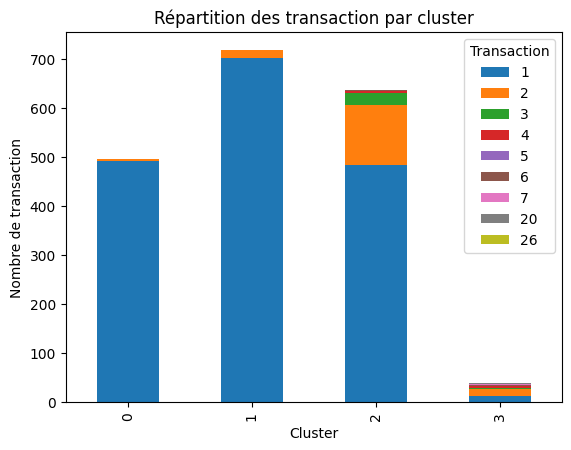

In [73]:
#Visualisation du nombre de transaction par cluster
#filtrage df avec au moins une transaction
df_final_ag_trans=df_final_ag.loc[df_final_ag['transaction']!=0]
# Créer une table de contingence entre cluster_label et transaction
contingency_table = pd.crosstab(df_final_ag_trans['cluster_label'], df_final_ag_trans['transaction'])

# Tracer le barplot
contingency_table.plot(kind='bar', stacked=True)

# Ajouter des étiquettes et des titres
plt.xlabel('Cluster')
plt.ylabel('Nombre de transaction')
plt.title('Répartition des transaction par cluster')

# Afficher la légende
plt.legend(title='Transaction')

# Afficher le graphique
plt.show()

Grâce à KMeans, quatre groupes distincts de comportement utilisateurs ont été identifiés. Une attention devrait être portée sur les clusters 1 et 3 qui pourraient représenter des niches de marché des opportunités de ventes additionnelles. Nous recommandons d'analyser les catégories de produits de ces clusters pour identifier des produits ou des offres qui ont une performance au-dessus de la moyenne.

Le score de silhouette montre une segmentation acceptable (0.73).

Le propriétaire du site pourrait envisager des stratégies marketing personnalisées pour chaque cluster, comme des recommandations de produits ou des campagnes de réengagement basées sur les préférences de chaque segment. Il doit également s'assurer de la disponibilité des produits qui pénalise le taux de conversion de prospects.

Priorité 1 : Nous avons le cluster 2 qui peut donc être isolé afin de mener des actions pour optimiser le parcours des clients sur le site, permettant théoriquement d'augmenter le taux de conversion. Il faudra améliorer de façon significative le taux de conversion auprès de cette cible en rendant les produits disponibles sur le site (33% de produits étant indisponible sur ce cluster).

Priorité 2 : Nous avons aussi le cluster 3 qui regroupe des acheteurs déjà fidèles au site auprès desquels on peut faire des actions promotionnelles pour augmenter les volumes d'achat.

Les cluster 0 et 1 seraient les plus difficiles à atteindre avec un taux d'indisponibilité des produits qui monte à 61% auprès du cluster 0 par exemple.

Au-delà des actions marketing, la disponibilité des produits pose un vrai problème.